# Compare single wake results in all cases

Expand comparison to all single wakes occuring in aligned simulations across 8-9 m/s

In [1]:
import matplotlib.pyplot as plt
import floris.tools as wfct
import numpy as np
import pandas as pd
import copy
import seaborn as sns
import pickle
from scipy.optimize import minimize

## Load FLORIS models and SOWFA DATA

In [2]:
df = pickle.load( open( "sowfa_04.p", "rb" ) )
fi_dict = pickle.load( open( "floris_models_2.p", "rb" ) )

In [3]:
# Make a color dict
color_dict = dict()
for floris_key in fi_dict:
    (fi, floris_color, floris_marker, floris_label) = fi_dict[floris_key]
    color_dict[floris_label] = floris_color

## Limit DF to tuning cases

In [4]:
print(df.shape)

(679, 21)


In [5]:
# Limit to aligned only
df = df[df.yaw.apply(lambda x: np.max(np.abs(x)))==0.0]

In [6]:
# Limit to 8 or 9 m/s (or not, comment out)
# df = df[df.sowfa_U0<10]
df.shape

(133, 21)

In [7]:
df[df.sowfa_U0==11]

,Precursor,case_name,floris_TI,floris_U0,layout_x,layout_y,num_turbines,path,sim_length,sowfa_TI,...,yaw,power,ti,d_spacing,wake_table,freestream_gauss,freestream_gauss_tune,freestream_gch_paper,freestream_legacy,freestream_ti
casename,,,,,,,,,,,,,,,,,,,,,
c_381,neutral_5kmx2kmx1km_11mps_lowTI\n,c_11_lowTI_D05_R-1_y00,0.055,10.97,"(1000.0, 1630.0)","(1000.0, 937.0)",2,sowfa_library (Paul.fleming@nrel.gov)/full_run...,2000.0,0.06,...,"[0.0, 0.0]","[4318.5, 2684.8]","[0.06079726257999932, 0.12479459970929428]",5.0,"[0, 1]",11.0,11.0,11.0,11.0,0.06
c_384,neutral_5kmx2kmx1km_11mps_lowTI\n,c_11_lowTI_D05_R00_y00,0.055,10.97,"(1000.0, 1630.0)","(1000.0, 1000.0)",2,sowfa_library (Paul.fleming@nrel.gov)/full_run...,2000.0,0.06,...,"[0.0, 0.0]","[4322.1, 1434.2]","[0.060739893776081265, 0.09765321960439531]",5.0,"[0, 1]",11.0,11.0,11.0,11.0,0.06
c_387,neutral_5kmx2kmx1km_11mps_lowTI\n,c_11_lowTI_D05_R01_y00,0.055,10.97,"(1000.0, 1630.0)","(1000.0, 1063.0)",2,sowfa_library (Paul.fleming@nrel.gov)/full_run...,2000.0,0.06,...,"[0.0, 0.0]","[4316.8, 2729.5]","[0.060875432155202164, 0.11850526575868739]",5.0,"[0, 1]",11.0,11.0,11.0,11.0,0.06
c_390,neutral_5kmx2kmx1km_11mps_lowTI\n,c_11_lowTI_D07_R-1_y00,0.055,10.97,"(1000.0, 1882.0)","(1000.0, 937.0)",2,sowfa_library (Paul.fleming@nrel.gov)/full_run...,2000.0,0.06,...,"[0.0, 0.0]","[4325.6, 2861.8]","[0.06067068942820764, 0.1354916286360716]",7.0,"[0, 1]",11.0,11.0,11.0,11.0,0.06
c_393,neutral_5kmx2kmx1km_11mps_lowTI\n,c_11_lowTI_D07_R00_y00,0.055,10.97,"(1000.0, 1882.0)","(1000.0, 1000.0)",2,sowfa_library (Paul.fleming@nrel.gov)/full_run...,2000.0,0.06,...,"[0.0, 0.0]","[4325.3, 1802.1]","[0.06070638011595635, 0.10978496451871307]",7.0,"[0, 1]",11.0,11.0,11.0,11.0,0.06
c_396,neutral_5kmx2kmx1km_11mps_lowTI\n,c_11_lowTI_D07_R01_y00,0.055,10.97,"(1000.0, 1882.0)","(1000.0, 1063.0)",2,sowfa_library (Paul.fleming@nrel.gov)/full_run...,2000.0,0.06,...,"[0.0, 0.0]","[4325.7, 2884.3]","[0.06068237845321636, 0.11924070866484261]",7.0,"[0, 1]",11.0,11.0,11.0,11.0,0.06
c_399,neutral_5kmx2kmx1km_11mps_lowTI\n,c_11_lowTI_D10_R-1_y00,0.055,10.97,"(1000.0, 2260.0)","(1000.0, 937.0)",2,sowfa_library (Paul.fleming@nrel.gov)/full_run...,2000.0,0.06,...,"[0.0, 0.0]","[4331.5, 3048.3]","[0.06052341810872191, 0.1238299511199133]",10.0,"[0, 1]",11.0,11.0,11.0,11.0,0.06
c_402,neutral_5kmx2kmx1km_11mps_lowTI\n,c_11_lowTI_D10_R00_y00,0.055,10.97,"(1000.0, 2260.0)","(1000.0, 1000.0)",2,sowfa_library (Paul.fleming@nrel.gov)/full_run...,2000.0,0.06,...,"[0.0, 0.0]","[4330.1, 2319.4]","[0.06057620508489943, 0.10537036106665079]",10.0,"[0, 1]",11.0,11.0,11.0,11.0,0.06
c_405,neutral_5kmx2kmx1km_11mps_lowTI\n,c_11_lowTI_D10_R01_y00,0.055,10.97,"(1000.0, 2260.0)","(1000.0, 1063.0)",2,sowfa_library (Paul.fleming@nrel.gov)/full_run...,2000.0,0.06,...,"[0.0, 0.0]","[4331.9, 3098.4]","[0.060461939948065604, 0.1076730856936299]",10.0,"[0, 1]",11.0,11.0,11.0,11.0,0.06


In [8]:
# Get the single wake results in all simulations
results_df = pd.DataFrame()

for floris_key in fi_dict:
    (fi, floris_color, floris_marker, floris_label) = fi_dict[floris_key]

    # Set up FLORIS to match
    # Determine free-stream wind speed column
    freestream_name = 'freestream_' + floris_label

    
    for i, row in df.iterrows():


        # Match the layout
        if (floris_label == 'gch_paper') or (floris_label == 'legacy') :
                fi.reinitialize_flow_field(layout_array=[row.layout_x,row.layout_y],
                               wind_speed=[row[freestream_name]],
                              turbulence_intensity=[row.floris_TI])
        else:
            fi.reinitialize_flow_field(layout_array=[row.layout_x,row.layout_y],
                                       wind_speed=[row[freestream_name]],
                                      turbulence_intensity=[row.freestream_ti])

        fi.calculate_wake()

        floris_power = np.array(fi.get_turbine_power())/1000.

        # Now sort out the powers by wakes
        upstream_idx = np.where(row.wake_table==0)
        sowfa_upstream_power = np.mean(row.power[upstream_idx])
        floris_upstream_power = np.mean(floris_power[upstream_idx])

        single_wake_indices = np.where(row.wake_table==1)
        single_wake_indices
        for idx in single_wake_indices:
            sowfa_downstream_power = np.mean(row.power[idx])
            floris_downstream_power = np.mean(floris_power[idx])

            # Make a dictionary entry for this row
            result_dict = {'sowfa_upstream_power':[sowfa_upstream_power],
                           'sowfa_downstream_power':[sowfa_downstream_power],
                           'floris_upstream_power':[floris_upstream_power],
                           'floris_downstream_power':[floris_downstream_power],
                           'sowfa_wake_loss':[sowfa_upstream_power - sowfa_downstream_power],
                           'floris_wake_loss':[floris_upstream_power - floris_downstream_power],
                           'floris_label':[floris_label],
                           'sowfa_U0':row.sowfa_U0,
                           'sowfa_TI':row.sowfa_TI
                          }
            # temp_df = 
            results_df = results_df.append(pd.DataFrame(result_dict))
    
results_df.head()

,sowfa_upstream_power,sowfa_downstream_power,floris_upstream_power,floris_downstream_power,sowfa_wake_loss,floris_wake_loss,floris_label,sowfa_U0,sowfa_TI
0,1937.5,1072.3,1937.499995,1150.425975,865.2,787.074020,gauss,8.0,0.1
0,1938.0,752.7,1937.999995,770.825801,1185.3,1167.174194,gauss,8.0,0.1
0,1936.5,1217.5,1936.499995,1149.624080,719.0,786.875915,gauss,8.0,0.1
0,1544.4,777.9,1544.399996,805.991562,766.5,738.408433,gauss,8.0,0.1
0,1940.5,849.7,1940.499995,891.203779,1090.8,1049.296216,gauss,8.0,0.1


## How do things compare?

/Users/pfleming/opt/anaconda3/envs/floris/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


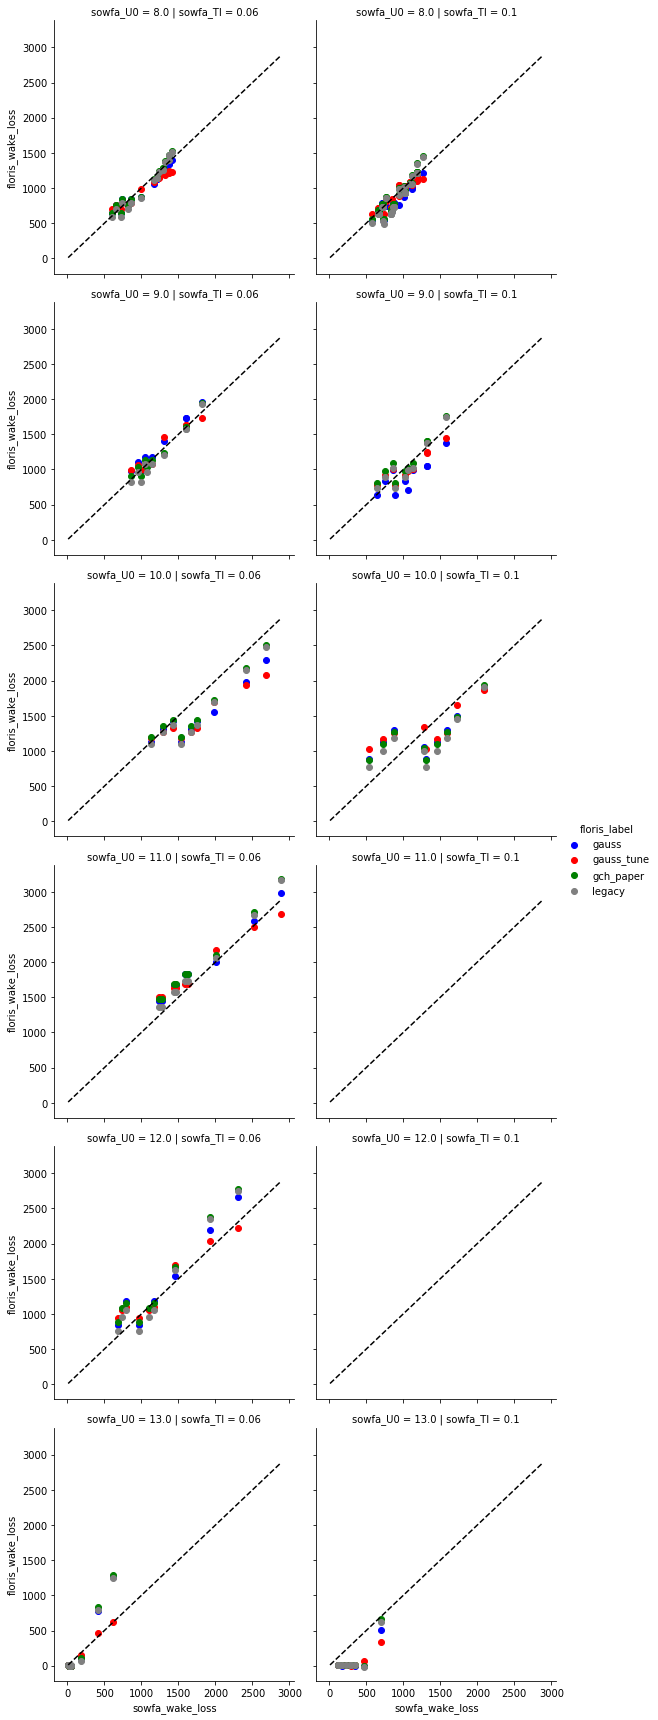

In [9]:
g = sns.FacetGrid(results_df,row='sowfa_U0', col='sowfa_TI',hue='floris_label',size=4,palette=color_dict)
g.map(plt.scatter,'sowfa_wake_loss','floris_wake_loss')
for ax in g.axes.flatten():
    ax.plot([results_df.sowfa_wake_loss.min(),results_df.sowfa_wake_loss.max()],
            [results_df.sowfa_wake_loss.min(),results_df.sowfa_wake_loss.max()],'k--')
g.add_legend()

/Users/pfleming/opt/anaconda3/envs/floris/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


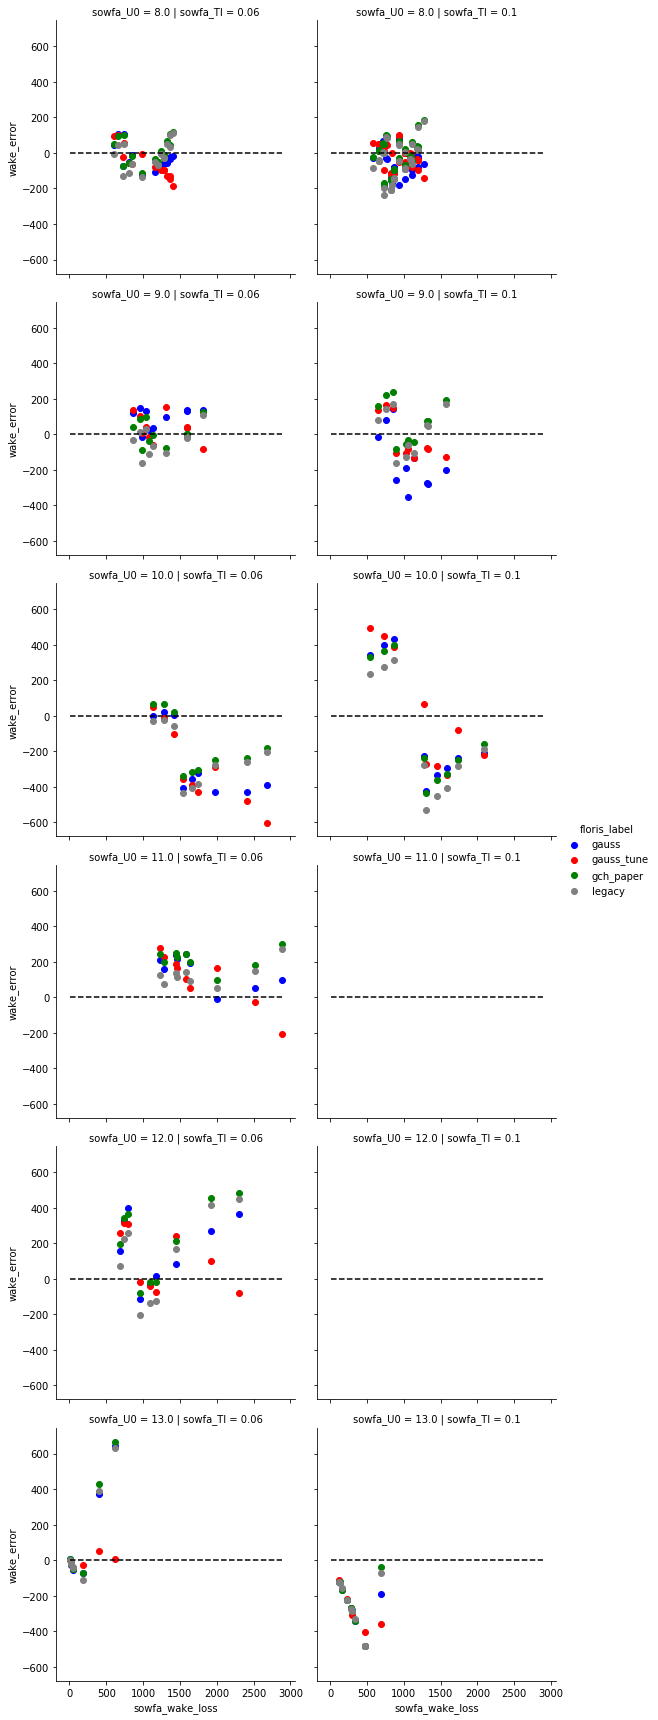

In [12]:
results_df['wake_error'] = results_df.floris_wake_loss - results_df.sowfa_wake_loss
g = sns.FacetGrid(results_df,row='sowfa_U0', col='sowfa_TI',hue='floris_label',size=4,palette=color_dict)
g.map(plt.scatter,'sowfa_wake_loss','wake_error')
for ax in g.axes.flatten():
    ax.plot([results_df.sowfa_wake_loss.min(),results_df.sowfa_wake_loss.max()],
            [0,0],'k--')
g.add_legend()

/Users/pfleming/opt/anaconda3/envs/floris/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


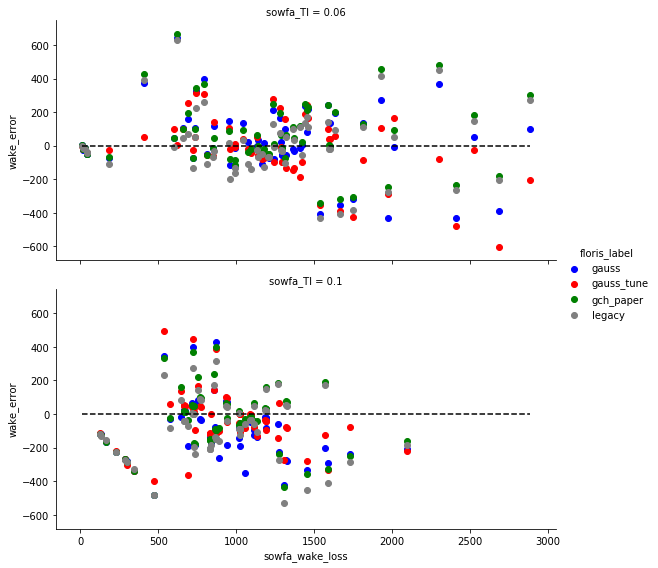

In [13]:
results_df['wake_error'] = results_df.floris_wake_loss - results_df.sowfa_wake_loss
g = sns.FacetGrid(results_df,row='sowfa_TI',hue='floris_label',size=4,aspect=2,palette=color_dict)
g.map(plt.scatter,'sowfa_wake_loss','wake_error')
for ax in g.axes.flatten():
    ax.plot([results_df.sowfa_wake_loss.min(),results_df.sowfa_wake_loss.max()],
            [0,0],'k--')
g.add_legend()

In [14]:
# Check for an overall bias and rms
results_df[['wake_error','floris_label']].groupby('floris_label').agg([np.mean,np.median,lambda x: np.sqrt(np.sum(x**2)/len(x))])

wake_error                       
                   mean     median    <lambda>
floris_label                                  
gauss        -36.852301 -41.503784  192.981721
gauss_tune   -34.818793 -33.120449  172.317526
gch_paper      6.062451 -13.507831  185.684061
legacy       -37.839599 -37.820385  185.015440

`We've reduced bias and RMS error across cases, new tuning seems acceptable